# Pipeline for High-z Radio Galaxies 04: Redshift prediction on radio AGN

## Introduction

Training for regression (prediction) of redshift for sources in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue. But regression  
will be done with AGN from the Million Quasar Catalog (MQC) and QSO from SDSS DR16.  
Only sources with confirmed $z$ will be used.

Being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import mpl_scatter_density
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
import cmasher as cmr
from pycaret import regression as pyr
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

Define specific metrics for redshift values:  

$$
\sigma_{\mathrm{NMAD}} = 1.48 \times \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

Methods to create values of metrics by redshift ranges

In [4]:
def z_metric_in_z_ranges(data_set_df, z_col, z_range, metric_function, *metricArgs):
    metric_output  = np.zeros_like(z_range)
    true_vals      = metricArgs[0]
    predicted_vals = metricArgs[1]
    for count, z_thresh in enumerate(z_range):
        filter_z             = data_set_df.loc[:, z_col] >= z_thresh
        if np.sum(filter_z) == 0:
            metric_output[count] = np.nan
            continue
        sub_set              = data_set_df.loc[filter_z, [*metricArgs]]
        metric_output[count] = metric_function(sub_set.loc[:, true_vals], sub_set.loc[:, predicted_vals])
    return metric_output

Method to plot metrics

In [5]:
def plot_metric_over_z(z_range, metric_range, name_metric, ax_pre, title=None, color=plt.get_cmap('cmr.redshift')(0.8)):
    ax_pre.plot(z_range, metric_range, color=color, zorder=10, alpha=0.93, marker='o', ls='-', lw=2.5)
    ##
    ax_pre.set_xlabel('$z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel(f'$\mathrm{{{name_metric}}} (\geq z)$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='major', labelsize=16)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_title(title, fontsize=14)
    ax_pre.grid(visible=True, alpha=0.1, zorder=0)
    plt.tight_layout()

***

## Reading data

In [6]:
save_plot_flag  = False
save_model_flag = False
read_idx_flag   = True
load_model_flag = True
use_calibration = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [7]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI', 
                      'TYPE', 'Sint_LOFAR', 'Sint_LOFAR_AB', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect', 
                      'Speak_LOFAR', 'rms_LOFAR', 'Sint_LOFAR_non_imp',
                      'Sint_LOFAR_AB_non_imp', 'Speak_LOFAR_non_imp', 'Sint_LOFAR_AB'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [8]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [9]:
full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'LOFAR_detect'].astype(int)

In [10]:
# full_catalog_df.describe()

#### Select only confirmed radio galaxies

In [11]:
n_full   = len(full_catalog_df)
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
print(f'In this dataset, with {n_full:,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, {n_is_gal:,} have been indentified as galaxies,' +\
      f' and {n_is_rad:,} are identified as radio detections (in LOFAR).')

In this dataset, with 15,136,878 elements,
50,538 of them are marked as AGN, 68,196 have been indentified as galaxies, and 382,430 are identified as radio detections (in LOFAR).


In [12]:
target_feat = 'Z'

---

Combine redshift values (AGN + galaxies).

In [13]:
idx_non_Z                = full_catalog_df.loc[:, target_feat].where(full_catalog_df.loc[:, target_feat] > 0).isna()
full_catalog_df.loc[idx_non_Z, target_feat] = full_catalog_df.loc[:, target_feat].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

---

## Possible correlations

In [14]:
print(full_catalog_df.columns.to_list())

['Z', 'zsp', 'spCl', 'band_num', 'LOFAR_detect', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4']


---

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`is_gal == 1` and `radio_detect == 1`).

In [15]:
filter_known_spec  = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
filter_known_radio = full_catalog_df.loc[:, 'LOFAR_detect'] == 1
full_catalog_df    = full_catalog_df.loc[filter_known_spec]
if not read_idx_flag:
    train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                                   'is_AGN', use_calibration=use_calibration)

if read_idx_flag:
    known_idx            = np.loadtxt(gv.indices_path + 'indices_known.txt')
    train_idx            = np.loadtxt(gv.indices_path + 'indices_train.txt')
    train_validation_idx = np.loadtxt(gv.indices_path + 'indices_train_validation.txt')  # in the future, fix naming
    validation_idx       = np.loadtxt(gv.indices_path + 'indices_validation.txt')  # in the future, fix naming
    calibration_idx      = np.loadtxt(gv.indices_path + 'indices_calibration.txt')
    test_idx             = np.loadtxt(gv.indices_path + 'indices_test.txt')
    
    train_test_df  = full_catalog_df.loc[train_validation_idx]
    train_df       = full_catalog_df.loc[train_idx]
    test_df        = full_catalog_df.loc[validation_idx]
    calibration_df = full_catalog_df.loc[calibration_idx]
    validation_df  = full_catalog_df.loc[test_idx]
    
print('Shape of used data in HETDEX')
print('-' * 65)
print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
print(f'Training data:                                    {train_df.shape}')
print(f'Testing data:                                     {test_df.shape}')
if use_calibration:
    print(f'Calibration data:                                 {calibration_df.shape}')
print(f'Validation data:                                  {validation_df.shape}')
print('-' * 65)
print()

Shape of used data in HETDEX
-----------------------------------------------------------------
Full confirmed dataset size:                      (118734, 88)
Data for Modeling (Train, Test, and Calibration): (94987, 88)
Training data:                                    (75989, 88)
Testing data:                                     (9499, 88)
Calibration data:                                 (9499, 88)
Validation data:                                  (23747, 88)
-----------------------------------------------------------------



In [16]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) & (full_catalog_df.loc[:, 'LOFAR_detect'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'is_gal'] == 1) & (train_test_df.loc[:, 'LOFAR_detect'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'is_gal'] == 1) & (train_df.loc[:, 'LOFAR_detect'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'is_gal'] == 1) & (test_df.loc[:, 'LOFAR_detect'] == 1)]
calibration_df  = calibration_df.loc[(calibration_df.loc[:, 'is_gal'] == 1) & (calibration_df.loc[:, 'LOFAR_detect'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'is_gal'] == 1) & (validation_df.loc[:, 'LOFAR_detect'] == 1)]

In [17]:
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_gal"]):,} elements,\n' +\
         f'{n_is_gal:,} of them are marked as galaxies, and, from them, {n_is_rad:,} have confirmed LOFAR radio detection.')

In this dataset (HETDEX), with 9,853 elements,
9,853 of them are marked as galaxies, and, from them, 9,853 have confirmed LOFAR radio detection.


Remove intermediate targets

In [18]:
cols_discard_class = ['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'LOFAR_detect', 'zsp']
full_catalog_df    = full_catalog_df.drop(columns=cols_discard_class)
train_test_df      = train_test_df.drop(columns=cols_discard_class)
train_df           = train_df.drop(columns=cols_discard_class)
test_df            = test_df.drop(columns=cols_discard_class)
calibration_df     = calibration_df.drop(columns=cols_discard_class)
validation_df      = validation_df.drop(columns=cols_discard_class)

---

In [19]:
print('Final shape of used data')
print('-' * 50)
print('Confirmed Radio AGN')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Calibration data:                   {calibration_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 50)

Final shape of used data
--------------------------------------------------
Confirmed Radio AGN
--------------------------------------------------
Full confirmed dataset size:        (9853, 80)
Data for Modeling (Train and Test): (7849, 80)
Training data:                      (6290, 80)
Testing data:                       (784, 80)
Calibration data:                   (775, 80)
Validation data:                    (2004, 80)
--------------------------------------------------


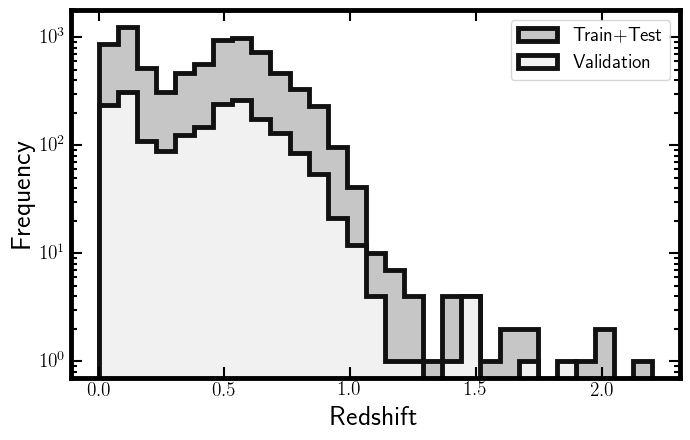

In [20]:
fig             = plt.figure(figsize=(7,4.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, target_feat])
max_score  = np.nanmax(full_catalog_df.loc[:, target_feat])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(train_test_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Train+Test')
ax1.hist(validation_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='Validation')

# ax1.axvline(x=3.7, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Save indices of sources in validation sub-set for future steps.

In [21]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [22]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [23]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [24]:
rsd_vals

K_W3        320.334206
i_z         139.874101
z_y         135.867079
i_y          80.959232
H_W3         80.422819
r_i          75.304824
g_r          71.129928
y_W2         67.005474
Z            64.459007
J_W3         61.391051
r_z          60.323946
z_W2         53.565224
J_H          52.470582
W1_W3        50.981808
r_y          50.198709
g_i          49.156848
H_K          49.135309
y_J          49.125352
i_W2         47.386239
g_z          46.208710
y_W1         43.940728
z_J          43.777150
y_H          43.229642
i_J          42.512950
g_y          42.191108
r_W2         42.183987
r_J          40.977404
y_K          39.985964
z_H          39.146804
z_W1         38.769600
i_H          38.545696
r_H          37.958997
z_K          36.990345
i_W1         36.843135
i_K          36.798653
W2_W3        36.771174
r_K          36.578835
g_J          36.426560
r_W1         36.033116
g_W2         35.264546
g_H          34.320476
y_W3         34.092675
g_K          33.796415
g_W1       

In [25]:
correlation = norm_train_test_df.corr()

In [26]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [27]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [28]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [29]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [30]:
list_drop_corr

['g_H',
 'r_H',
 'i_H',
 'g_K',
 'z_H',
 'y_H',
 'r_K',
 'gmag',
 'g_W1',
 'rmag',
 'i_K',
 'J_W2',
 'r_W1',
 'W1mproPM',
 'z_K',
 'J_W3',
 'J_W1',
 'imag',
 'y_K',
 'W2_W4',
 'zmag',
 'ymag',
 'Jmag',
 'K_W1',
 'g_W4',
 'i_W1',
 'J_W4',
 'W2_W3',
 'r_W4',
 'z_W1',
 'H_W2',
 'K_W2',
 'y_W1',
 'i_W4',
 'z_W4',
 'W3mag',
 'W2mproPM',
 'y_W4',
 'g_W3',
 'g_W2',
 'r_J',
 'Kmag',
 'r_W3',
 'H_W3',
 'z_W3',
 'g_y',
 'i_J',
 'z_J',
 'J_K',
 'i_W3',
 'g_z',
 'Hmag',
 'W3_W4',
 'H_W1',
 'K_W4',
 'r_W2',
 'i_W2',
 'z_W2',
 'y_W3',
 'r_y',
 'g_J',
 'band_num',
 'g_i',
 'H_W4',
 'W1_W4']

In [31]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [32]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [33]:
corr_discard = norm_train_test_discard.corr()

In [34]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

Z      Z        1.000000
y_J    Z        0.755637
r_i    r_z      0.718559
y_W2   y_J      0.710570
i_z    i_y      0.626415
Z      H_K      0.612831
r_z    Z        0.583041
W4mag  K_W3     0.566784
i_y    z_y      0.544642
r_z    i_z      0.531743
y_J    H_K      0.497581
Z      K_W3     0.474152
r_z    y_J      0.472564
Z      r_i      0.439648
H_K    W1_W3    0.429388
dtype: float64

Text(1052.0930609538775, 0.5, 'feature')

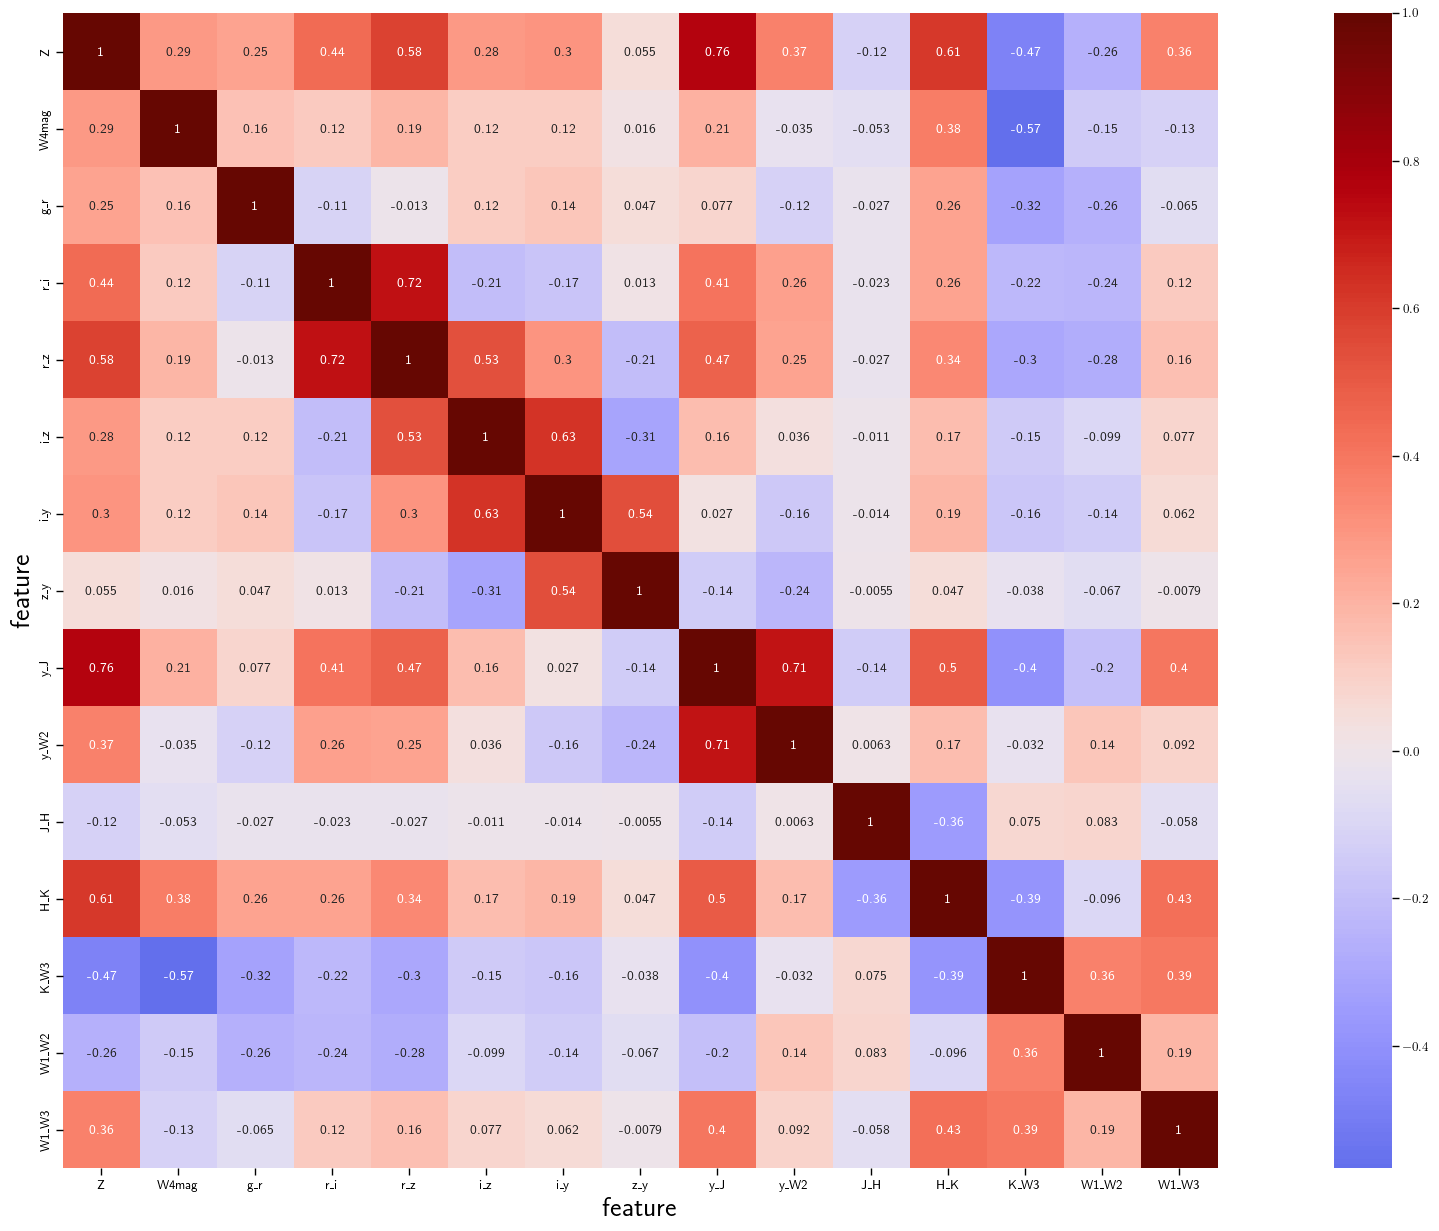

In [35]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [36]:
# norm_train_test_discard.loc[:, target_feat] = norm_train_test_discard.loc[:, target_feat].astype(bool)

In [37]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [38]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x      y    
H_K    H_K      1.000000
J_H    H_K      0.415777
y_J    Z        0.402650
K_W3   Z        0.389769
H_K    Z        0.387609
J_H    Z        0.383487
r_z    r_i      0.303165
Z      y_J      0.302568
J_H    y_J      0.294858
H_K    y_J      0.278275
r_i    r_z      0.272310
r_z    Z        0.270374
K_W3   y_J      0.235284
r_i    Z        0.200583
K_W3   H_K      0.155345
r_z    y_J      0.143810
K_W3   W1_W3    0.126322
Z      H_K      0.123997
W1_W2  Z        0.121282
W4mag  Z        0.112752
dtype: float64

In [39]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [40]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [41]:
list_drop_pps = []

In [42]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [43]:
list_drop_pps

[]

In [44]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [45]:
pps_pred_target = pps.predictors(norm_train_test_discard, target_feat, random_seed=gv.seed)

In [46]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,y_J,Z,0.402650,regression,True,mean absolute error,0.101762,0.060788,DecisionTreeRegressor()
1,K_W3,Z,0.389769,regression,True,mean absolute error,0.101762,0.062099,DecisionTreeRegressor()
2,H_K,Z,0.387609,regression,True,mean absolute error,0.101762,0.062318,DecisionTreeRegressor()
3,J_H,Z,0.383487,regression,True,mean absolute error,0.101762,0.062738,DecisionTreeRegressor()
4,r_z,Z,0.270374,regression,True,mean absolute error,0.101762,0.074249,DecisionTreeRegressor()
5,r_i,Z,0.200583,regression,True,mean absolute error,0.101762,0.081351,DecisionTreeRegressor()
6,W1_W2,Z,0.121282,regression,True,mean absolute error,0.101762,0.089420,DecisionTreeRegressor()
7,W4mag,Z,0.112752,regression,True,mean absolute error,0.101762,0.090289,DecisionTreeRegressor()
8,g_r,Z,0.095679,regression,True,mean absolute error,0.101762,0.092026,DecisionTreeRegressor()
9,i_y,Z,0.049873,regression,True,mean absolute error,0.101762,0.096687,DecisionTreeRegressor()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [47]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta
# final_feats.remove('band_num')       # After Boruta

In [48]:
feats_2_discard = list_drop_corr + list_drop_pps #  + ['band_num']

Boruta discards one feature.

In [49]:
exp_radio = pyr.setup(data                     = train_df,
                      test_data                = test_df,
                      target                   = target_feat,
                      session_id               = gv.seed,
                      silent                   = True,
                      feature_selection        = False,
                      feature_selection_method = 'boruta',
                      numeric_features         = final_feats,
                      ignore_features          = feats_2_discard,
                      transformation           = True,
                      transformation_method    = 'yeo-johnson',
                      n_jobs                   = 12,
                      normalize                = True,
                      normalize_method         = 'zscore',
                      use_gpu                  = False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,Z
2,Original Data,"(6290, 80)"
3,Missing Values,False
4,Numeric Features,14
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6290, 14)"


Add custom metrics

In [50]:
pyr.add_metric('s_mad',  'sigma_mad',    gf.sigma_mad,    greater_is_better=False)
pyr.add_metric('s_nmad', 'sigma_nmad',   gf.sigma_nmad,   greater_is_better=False)
pyr.add_metric('s_z',    'sigma_z',      gf.sigma_z,      greater_is_better=False)
pyr.add_metric('s_z_n',  'sigma_z_norm', gf.sigma_z_norm, greater_is_better=False)
pyr.add_metric('out_f',  'outlier_fr',   gf.outlier_frac, greater_is_better=False)

Name                                                        outlier_fr
Display Name                                                outlier_fr
Score Function               <function outlier_frac at 0x7f69a9cb71f0>
Scorer               make_scorer(outlier_frac, greater_is_better=Fa...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: out_f, dtype: object

In [51]:
pyr.get_config('X').columns

Index(['W4mag', 'g_r', 'r_i', 'r_z', 'i_z', 'i_y', 'z_y', 'y_J', 'y_W2', 'J_H',
       'H_K', 'K_W3', 'W1_W2', 'W1_W3'],
      dtype='object')

In [52]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [53]:
pyr.models(internal=True).loc['rf']['Tune Grid'].keys()

dict_keys(['n_estimators', 'max_depth', 'min_impurity_decrease', 'max_features', 'bootstrap', 'criterion', 'min_samples_split', 'min_samples_leaf'])

In [54]:
pyr.models(internal=True).loc['et']['Tune Grid'].keys()

dict_keys(['n_estimators', 'criterion', 'max_depth', 'min_impurity_decrease', 'max_features', 'bootstrap', 'min_samples_split', 'min_samples_leaf'])

In [55]:
pyr.models(internal=True).loc['catboost']['Tune Grid'].keys()

dict_keys(['eta', 'depth', 'n_estimators', 'random_strength', 'l2_leaf_reg'])

In [56]:
pyr.models(internal=True).loc['xgboost']['Tune Grid'].keys()

dict_keys(['learning_rate', 'n_estimators', 'subsample', 'max_depth', 'colsample_bytree', 'min_child_weight', 'reg_alpha', 'reg_lambda', 'scale_pos_weight'])

In [57]:
pyr.models(internal=True).loc['gbr']['Tune Grid'].keys()

dict_keys(['n_estimators', 'learning_rate', 'subsample', 'min_samples_split', 'min_samples_leaf', 'max_depth', 'min_impurity_decrease', 'max_features'])

In [58]:
dummy_median = DummyRegressor(strategy='median')

In [59]:
rf = pyr.create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.0478,0.0080,0.0895,0.8890,0.0582,0.1890,0.0378,0.0276,0.0895,0.0630,0.0270
1,0.0488,0.0082,0.0908,0.8785,0.0628,0.2295,0.0381,0.0286,0.0908,0.0698,0.0366
2,0.0446,0.0081,0.0901,0.8822,0.0524,0.1685,0.0374,0.0266,0.0901,0.0488,0.0175
3,0.0585,0.0130,0.1139,0.8058,0.0785,0.2133,0.0402,0.0297,0.1139,0.0911,0.0509
4,0.0512,0.0092,0.0960,0.8775,0.0595,0.2227,0.0383,0.0291,0.0960,0.0598,0.0366
5,0.0543,0.0115,0.1070,0.8550,0.0676,0.2171,0.0392,0.0288,0.1070,0.0732,0.0270
6,0.0518,0.0096,0.0977,0.8622,0.0653,0.2038,0.0404,0.0293,0.0977,0.0785,0.0334
7,0.0527,0.0119,0.1089,0.8302,0.0667,0.1848,0.0377,0.0268,0.1089,0.0664,0.0302
8,0.0483,0.0075,0.0869,0.8835,0.0605,0.1738,0.0391,0.0288,0.0869,0.0692,0.0223


In [60]:
et = pyr.create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.0482,0.0081,0.0901,0.8876,0.0586,0.1905,0.0359,0.0260,0.0901,0.0634,0.0254
1,0.0473,0.0077,0.0879,0.8862,0.0603,0.1973,0.0365,0.0272,0.0879,0.0672,0.0270
2,0.0441,0.0083,0.0914,0.8789,0.0526,0.1576,0.0351,0.0262,0.0914,0.0496,0.0175
3,0.0583,0.0121,0.1099,0.8195,0.0751,0.1962,0.0411,0.0302,0.1099,0.0878,0.0493
4,0.0529,0.0106,0.1028,0.8596,0.0631,0.2185,0.0410,0.0291,0.1028,0.0620,0.0302
5,0.0561,0.0117,0.1080,0.8522,0.0671,0.1965,0.0426,0.0318,0.1080,0.0714,0.0302
6,0.0514,0.0097,0.0987,0.8594,0.0651,0.2023,0.0395,0.0287,0.0987,0.0795,0.0270
7,0.0523,0.0119,0.1091,0.8296,0.0669,0.1749,0.0371,0.0263,0.1091,0.0656,0.0302
8,0.0482,0.0082,0.0904,0.8737,0.0634,0.1700,0.0361,0.0273,0.0904,0.0743,0.0302


In [61]:
ctbst = pyr.create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.0489,0.0084,0.0919,0.8831,0.0590,0.1937,0.0367,0.0278,0.0919,0.0628,0.0254
1,0.0470,0.0073,0.0857,0.8919,0.0597,0.2197,0.0387,0.0280,0.0857,0.0668,0.0286
2,0.0459,0.0083,0.0913,0.8791,0.0530,0.1722,0.0373,0.0285,0.0913,0.0514,0.0191
3,0.0561,0.0114,0.1068,0.8294,0.0732,0.1991,0.0417,0.0307,0.1068,0.0861,0.0397
4,0.0525,0.0108,0.1041,0.8559,0.0640,0.2151,0.0395,0.0290,0.1041,0.0625,0.0318
5,0.0540,0.0107,0.1034,0.8646,0.0644,0.1994,0.0407,0.0310,0.1034,0.0694,0.0270
6,0.0519,0.0103,0.1017,0.8508,0.0668,0.2094,0.0434,0.0305,0.1017,0.0836,0.0334
7,0.0520,0.0110,0.1046,0.8431,0.0646,0.1812,0.0403,0.0296,0.1046,0.0641,0.0254
8,0.0484,0.0079,0.0889,0.8780,0.0623,0.1685,0.0413,0.0297,0.0889,0.0741,0.0254


In [62]:
xgbst = pyr.create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.0537,0.0092,0.0958,0.8727,0.0615,0.2004,0.0468,0.0346,0.0958,0.0652,0.0318
1,0.0518,0.0087,0.0935,0.8712,0.0649,0.2320,0.0391,0.0298,0.0935,0.0732,0.0318
2,0.0471,0.0081,0.0902,0.8819,0.0531,0.1802,0.0388,0.0288,0.0902,0.0501,0.0159
3,0.0614,0.0127,0.1126,0.8105,0.0777,0.2135,0.0463,0.0331,0.1126,0.0894,0.0445
4,0.0549,0.0097,0.0986,0.8710,0.0612,0.2268,0.0418,0.0312,0.0986,0.0606,0.0397
5,0.0573,0.0125,0.1118,0.8418,0.0697,0.2248,0.0419,0.0299,0.1118,0.0751,0.0318
6,0.0536,0.0093,0.0965,0.8656,0.0650,0.2297,0.0438,0.0316,0.0965,0.0770,0.0334
7,0.0566,0.0126,0.1121,0.8198,0.0679,0.1922,0.0449,0.0327,0.1121,0.0680,0.0302
8,0.0511,0.0074,0.0862,0.8853,0.0593,0.1773,0.0422,0.0316,0.0862,0.0656,0.0254


In [63]:
gbr = pyr.create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.0570,0.0095,0.0977,0.8678,0.0638,0.2460,0.0468,0.0352,0.0977,0.0683,0.0366
1,0.0545,0.0087,0.0932,0.8719,0.0650,0.2484,0.0469,0.0344,0.0932,0.0716,0.0382
2,0.0510,0.0084,0.0919,0.8774,0.0539,0.1969,0.0466,0.0350,0.0919,0.0511,0.0191
3,0.0648,0.0136,0.1164,0.7973,0.0797,0.2406,0.0510,0.0358,0.1164,0.0913,0.0572
4,0.0577,0.0096,0.0980,0.8723,0.0615,0.2571,0.0501,0.0371,0.0980,0.0624,0.0461
5,0.0598,0.0117,0.1083,0.8515,0.0681,0.2493,0.0484,0.0357,0.1083,0.0713,0.0318
6,0.0582,0.0098,0.0989,0.8590,0.0667,0.2373,0.0487,0.0360,0.0989,0.0754,0.0270
7,0.0569,0.0107,0.1036,0.8462,0.0642,0.2096,0.0493,0.0352,0.1036,0.0654,0.0270
8,0.0545,0.0081,0.0898,0.8755,0.0630,0.2046,0.0473,0.0355,0.0898,0.0702,0.0366


In [64]:
dummy_mn = pyr.create_model(dummy_median)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2294,0.0733,0.2707,-0.0150,0.1956,1.9111,0.3411,0.2139,0.2707,0.2120,0.4897
1,0.2304,0.0709,0.2662,-0.0439,0.1966,1.8979,0.3692,0.2432,0.2662,0.2160,0.5246
2,0.2223,0.0701,0.2648,-0.0172,0.1902,1.6791,0.3248,0.2035,0.2648,0.2053,0.4817
3,0.2180,0.0676,0.2601,-0.0117,0.1875,1.5494,0.3043,0.2023,0.2601,0.2025,0.4595
4,0.2309,0.0758,0.2753,-0.0064,0.1957,1.7811,0.3324,0.2181,0.2753,0.2095,0.4928
5,0.2383,0.0799,0.2826,-0.0109,0.2009,1.7640,0.3623,0.2355,0.2826,0.2158,0.5183
6,0.2281,0.0700,0.2646,-0.0102,0.1917,1.8800,0.3415,0.2201,0.2646,0.2071,0.4944
7,0.2235,0.0709,0.2663,-0.0159,0.1911,1.5663,0.3328,0.2127,0.2663,0.2060,0.4881
8,0.2204,0.0673,0.2595,-0.0395,0.1911,1.7254,0.3188,0.2015,0.2595,0.2096,0.4642


In [65]:
metric_2_opt          = 's_mad'

In [66]:
# final_selection_reg   = ['rf', 'et', 'catboost', 'xgboost', 'gbr', 'dummy']  # knn discarded: no feature importances
final_selection_reg   = [et, rf, ctbst, xgbst, gbr, dummy_mn]
initial_selection_reg = ['rf', 'et', 'gbr', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm, dt)
n_models              = 5
top_model_z           = pyr.compare_models(n_select = n_models,
                                           include  = final_selection_reg,
                                           sort     = metric_2_opt)  # 1:15 hour for used_models_clf
# top_model_z           = pyr.compare_models(n_select=n_models, include=initial_selection_reg, sort=metric_2_opt)  # 5 minutes, using all models.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr,TT (Sec)
0,Extra Trees Regressor,0.0509,0.0098,0.0989,0.8597,0.0639,0.1881,0.0385,0.0281,0.0989,0.0703,0.0291,0.1670
1,Random Forest Regressor,0.0509,0.0096,0.0978,0.8625,0.0637,0.1994,0.0389,0.0286,0.0978,0.0698,0.0308,0.3760
2,CatBoost Regressor,0.0507,0.0096,0.0975,0.8640,0.0632,0.1943,0.0401,0.0296,0.0975,0.0699,0.0278,1.0440
3,Extreme Gradient Boosting,0.0541,0.0100,0.0998,0.8572,0.0646,0.2059,0.0431,0.0316,0.0998,0.0705,0.0313,12.7490
4,Gradient Boosting Regressor,0.0569,0.0100,0.0996,0.8578,0.0653,0.2308,0.0481,0.0354,0.0996,0.0705,0.0345,0.2390
5,Dummy Regressor,0.2269,0.0715,0.2674,-0.0193,0.1933,1.7460,0.3351,0.2170,0.2674,0.2094,0.4908,0.0080


Thus, we select `et` as meta learner. It has the best mean rank and best sigma_mad value.

Thus, we stack the models.

In [55]:
base_models = top_model_z[1:]
meta_model  = top_model_z[0]
# base_models = top_model_z[0:1] + top_model_z[2:]
# meta_model  = top_model_z[1]

In [56]:
stacked_model_z = pyr.stack_models(estimator_list = base_models,
                                   meta_model     = meta_model,
                                   optimize       = metric_2_opt, 
                                   restack        = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.0469,0.0072,0.0851,0.8996,0.0556,0.1845,0.0389,0.0281,0.0851,0.0609,0.0223
1,0.0467,0.0077,0.0880,0.8858,0.0607,0.1950,0.0355,0.0279,0.0880,0.0683,0.0318
2,0.0439,0.0078,0.0882,0.8871,0.0508,0.1577,0.0354,0.0261,0.0882,0.0474,0.0207
3,0.0566,0.0117,0.1082,0.8248,0.0735,0.1807,0.0403,0.0292,0.1082,0.0847,0.0397
4,0.0502,0.0083,0.0909,0.8903,0.0560,0.1908,0.0374,0.0286,0.0909,0.0567,0.0302
5,0.0524,0.0111,0.1054,0.8594,0.0654,0.1757,0.0400,0.0284,0.1054,0.0697,0.0254
6,0.0507,0.0093,0.0966,0.8653,0.0641,0.1927,0.0392,0.0283,0.0966,0.0769,0.0286
7,0.0500,0.0109,0.1046,0.8434,0.0638,0.1651,0.0357,0.0276,0.1046,0.0641,0.0254
8,0.0470,0.0083,0.0911,0.8720,0.0623,0.1545,0.0387,0.0275,0.0911,0.0764,0.0238


In [61]:
# rf_tune_grid                 = pyr.models(internal=True).loc['rf']['Tune Grid']
# rf_tune_grid['max_depth']    = [3, 4, 5, 6, 7, 8, 9, 10, 11]  # old = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# rf_tune_grid['max_features'] = [0.25, 0.33, 0.66]  # old = [1.0, 'sqrt', 'log2']

In [57]:
# tuned_z_reg = pyr.tune_model(estimator        = stacked_model_z,
#                              early_stopping   = True,
#                              optimize         = metric_2_opt,
#                              search_library   = 'tune-sklearn',
#                              search_algorithm = 'bayesian',
#                              choose_better    = True,
#                              custom_grid      = rf_tune_grid)  # 1h30
tuned_z_reg = pyr.tune_model(estimator        = stacked_model_z,
                             early_stopping   = True,
                             optimize         = metric_2_opt,
                             search_library   = 'tune-sklearn',
                             search_algorithm = 'bayesian',
                             choose_better    = True)  # 1h30

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.0475,0.0078,0.0881,0.8925,0.0569,0.1868,0.0365,0.0271,0.0881,0.0619,0.0302
1,0.0466,0.0075,0.0868,0.8890,0.0601,0.2026,0.0364,0.0275,0.0868,0.0674,0.0286
2,0.0427,0.0073,0.0857,0.8935,0.0490,0.1587,0.0348,0.0267,0.0857,0.0459,0.0143
3,0.0564,0.0120,0.1097,0.8201,0.0745,0.1873,0.0396,0.0287,0.1097,0.0868,0.0397
4,0.0500,0.0087,0.0934,0.8843,0.0570,0.2006,0.0382,0.0277,0.0934,0.0569,0.0286
5,0.0522,0.0102,0.1012,0.8703,0.0627,0.1882,0.0379,0.0276,0.1012,0.0664,0.0270
6,0.0500,0.0081,0.0899,0.8834,0.0608,0.2017,0.0422,0.0294,0.0899,0.0694,0.0286
7,0.0506,0.0108,0.1039,0.8453,0.0635,0.1703,0.0376,0.0273,0.1039,0.0638,0.0238
8,0.0463,0.0071,0.0845,0.8899,0.0589,0.1580,0.0383,0.0276,0.0845,0.0683,0.0223


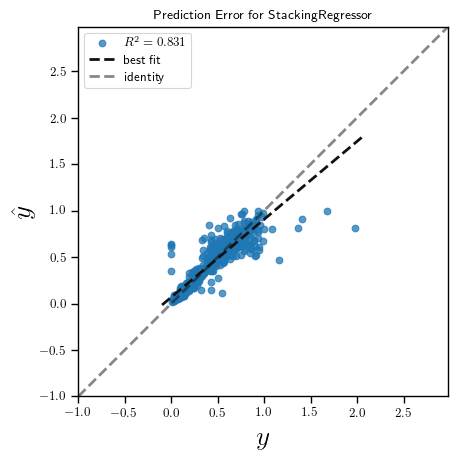

In [58]:
pyr.plot_model(tuned_z_reg, plot='error')

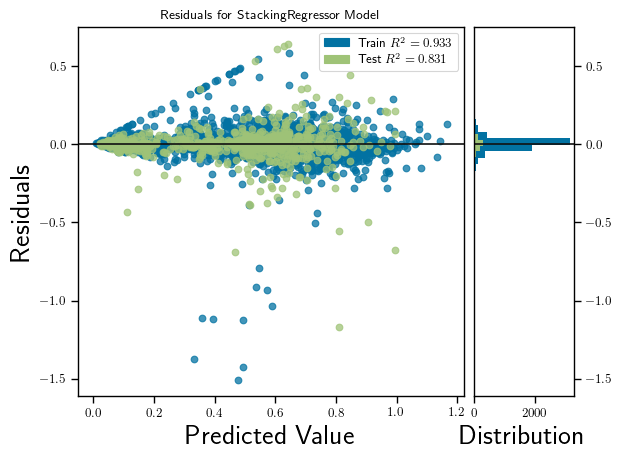

In [59]:
pyr.plot_model(tuned_z_reg, plot='residuals')

In [77]:
# pyr.plot_model(tuned_z_reg.final_estimator_, plot='feature_all')

In [60]:
pyr.plot_model(tuned_z_reg.final_estimator_, plot='parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,mse
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None
min_samples_leaf,1


In [61]:
pyr.plot_model(tuned_z_reg.final_estimator, plot='parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,mse
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None
min_samples_leaf,1


In [62]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True

In [63]:
pyr.predict_model(tuned_z_reg).loc[:, [target_feat, 'Label']].describe()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0558,0.0120,0.1097,0.8311,0.0678,0.1476,0.0395,0.0284,0.1097,0.0715,0.0383


,Z,Label
count,784.000000,784.000000
mean,0.432370,0.430308
std,0.267227,0.245907
min,0.000000,0.020634
25%,0.160565,0.162656
50%,0.474925,0.501211
75%,0.607532,0.615272
max,1.975860,0.994557


In [64]:
test_prediction_reg = pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0558,0.0120,0.1097,0.8311,0.0678,0.1476,0.0395,0.0284,0.1097,0.0715,0.0383


In [65]:
final_z_reg = pyr.finalize_model(tuned_z_reg)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: Futur

In [66]:
pyr.predict_model(final_z_reg).loc[:, [target_feat, 'Label']].describe()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0558,0.0120,0.1097,0.8311,0.0678,0.1476,0.0395,0.0284,0.1097,0.0715,0.0383


,Z,Label
count,784.000000,784.000000
mean,0.432370,0.430308
std,0.267227,0.245907
min,0.000000,0.020634
25%,0.160565,0.162656
50%,0.474925,0.501211
75%,0.607532,0.615272
max,1.975860,0.994557


In [67]:
if save_model_flag:
    pyr.save_model(final_z_reg, gv.models_path + gv.z_radio_galaxies_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [51]:
if load_model_flag:
    final_z_reg = pyr.load_model(gv.models_path + gv.z_radio_galaxies_model)

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [52]:
base_models_names = gf.get_base_estimators_names(final_z_reg)
base_models       = gf.get_base_estimators_models(final_z_reg)

In [53]:
print('Running data pre-processing:\n')
extended_data_z_df = gf.preprocess_data(final_z_reg, validation_df, base_models_names)

Running data pre-processing:



In [54]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_z_reg, extended_data_z_df)

In [55]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_z_df)

In [56]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [57]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for rf...
Calculating for catboost...
Calculating for xgboost...
Calculating for gbr...


rf            catboost            xgboost                gbr  \
   Feature Importance  Feature Importance Feature Importance Feature   
0      y_J  67.826600      y_J  31.668494     y_J  68.710152     y_J   
1      g_r   8.585822      g_r  11.353303     g_r   4.752092     g_r   
2    W1_W2   4.866648    W1_W2  10.001339     J_H   4.083099     r_z   
3      r_z   4.120817      r_z   8.847266     r_z   3.382936    y_W2   
4     y_W2   3.781268     y_W2   7.665951     H_K   3.265643   W1_W2   
5      i_y   2.339599    W1_W3   5.515226    y_W2   3.115971     H_K   
6      r_i   2.295434      i_y   5.437104   W1_W2   2.521893     i_y   
7    W1_W3   1.819493      H_K   4.875894     i_y   2.282407     r_i   
8      i_z   1.351365      r_i   4.327637    K_W3   1.771751   W1_W3   
9      z_y   1.258755     K_W3   3.923099     r_i   1.606269    K_W3   
10     H_K   0.698322      z_y   2.833257   W1_W3   1.390551     J_H   
11     J_H   0.479080      i_z   2.577302     i_z   1.341448     i_z   
12    K_W3   0.443141      J_H   0.750108     z_y   1.292631     z_y   
13   W4mag   0.133656    W4mag   0.224020   W4mag   0.483152   W4mag   

               
   Importance  
0   73.757244  
1    8.045276  
2    4.555819  
3    3.055882  
4    2.503261  
5    2.142351  
6    2.104840  
7    1.375205  
8    0.958964  
9    0.552706  
10   0.363272  
11   0.357511  
12   0.154774  
13   0.072894

In [58]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
coef_sorted_meta_df_copy_sum['Cumulative_sum'] = coef_sorted_meta_df_copy_sum.loc[:, 'Importance'].cumsum()
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance,Cumulative_sum
0,catboost,25.148080,25.148080
1,gbr,24.848431,49.996512
2,xgboost,17.966386,67.962897
3,rf,15.567918,83.530815
4,y_J,5.087259,88.618075
5,W1_W2,1.626149,90.244224
6,r_z,1.572367,91.816591
7,H_K,1.333489,93.150080
8,r_i,0.992049,94.142129
9,W1_W3,0.957202,95.099332


In [59]:
print('Combined feature importances scaled to sum 100')
coef_sorted_comb_sum = coef_sorted_meta_df_copy_sum.copy().set_index('Feature')
for key in coef_sorted_base_df_copy_sum.keys():
    factor = coef_sorted_meta_df_copy_sum.set_index('Feature').loc[key] / 100
    tmp_feat_imp = coef_sorted_base_full_df.loc[:, key].copy().set_index('Feature')
    coef_sorted_comb_sum = coef_sorted_comb_sum + tmp_feat_imp * factor
    coef_sorted_comb_sum = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=False)#.drop(index=base_models_names)
    coef_sorted_comb_sum['Cumulative_sum'] = coef_sorted_comb_sum.loc[:, 'Importance'].cumsum()
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_comb_sum.drop(index=base_models_names))

Combined feature importances scaled to sum 100


,Cumulative_sum,Importance
Feature,,
y_J,54.2827,54.2827
g_r,62.0903,7.8076
r_z,68.2689,6.1787
W1_W2,74.2430,5.9740
y_W2,78.8314,4.5884
H_K,82.6188,3.7875
i_y,86.0850,3.4662
W1_W3,89.2006,3.1156
r_i,92.2686,3.0680


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
y_J	54.283
g_r	7.808
r_z	6.179
W1_W2	5.974
y_W2	4.588
H_K	3.787
i_y	3.466
W1_W3	3.116
r_i	3.068
K_W3	2.185
i_z	1.838
z_y	1.825
J_H	1.339
W4mag	0.545


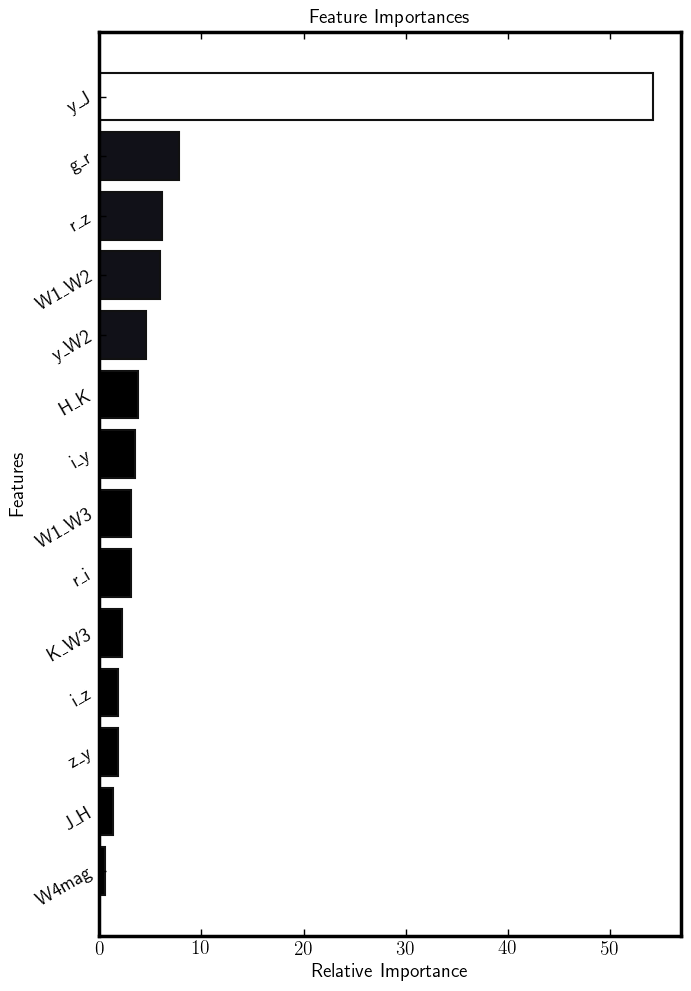

In [60]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    features_df = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=True).drop(index=base_models_names)
    features    = features_df.index.to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), importances,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_regression_z_04.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(importances)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [61]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_z_reg, 'et', 'regression')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,et,rf,catboost,xgboost,gbr
n_estimators,100,100.0000,NaN,100.0000,100.0000
criterion,mse,mse,NaN,NaN,NaN
max_depth,None,NaN,NaN,6.0000,3.0000
min_impurity_decrease,0.0000,0.0000,NaN,NaN,0.0000
max_features,auto,auto,NaN,NaN,None
bootstrap,False,True,NaN,NaN,NaN
min_samples_split,2,2.0000,NaN,NaN,2.0000
min_samples_leaf,1,1.0000,NaN,NaN,1.0000
learning_rate,NaN,NaN,0.0547,0.3000,0.1000
depth,NaN,NaN,6.0000,NaN,NaN


---

In [62]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 6,290
Size of test set is  784


In [63]:
train_prediction_reg      = pyr.predict_model(final_z_reg, data=train_df)
test_prediction_reg       = pyr.predict_model(final_z_reg, data=test_df)
train_test_prediction_reg = pyr.predict_model(final_z_reg, data=train_test_df)
calib_prediction_reg      = pyr.predict_model(final_z_reg, data=calibration_df)
validation_prediction_reg = pyr.predict_model(final_z_reg, data=validation_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0292,0.0047,0.0687,0.9329,0.0418,0.0924,0.0201,0.0145,0.0687,0.0413,0.0089


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0558,0.0120,0.1097,0.8311,0.0678,0.1476,0.0395,0.0284,0.1097,0.0715,0.0383


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0345,0.0065,0.0807,0.9080,0.0493,0.1066,0.0228,0.0169,0.0807,0.0503,0.0144


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0559,0.0154,0.1243,0.7881,0.0760,0.1798,0.0388,0.0278,0.1243,0.0812,0.0348


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0525,0.0109,0.1044,0.8484,0.0657,0.2784,0.0386,0.0289,0.1044,0.0709,0.0279


In [64]:
validation_prediction_reg.loc[:, [target_feat, 'Label']].describe()

,Z,Label
count,2004.000000,2004.000000
mean,0.413818,0.413423
std,0.268146,0.248786
min,0.000000,0.021351
25%,0.136877,0.139881
50%,0.447040,0.469356
75%,0.604455,0.608766
max,1.838030,1.159524


In [65]:
sigma_mad_train         = gf.sigma_mad(train_prediction_reg.loc[:, target_feat],         train_prediction_reg.loc[:, 'Label'])
sigma_mad_test          = gf.sigma_mad(test_prediction_reg.loc[:, target_feat],          test_prediction_reg.loc[:, 'Label'])
sigma_mad_train_test    = gf.sigma_mad(train_test_prediction_reg.loc[:, target_feat],    train_test_prediction_reg.loc[:, 'Label'])
sigma_mad_calib         = gf.sigma_mad(calib_prediction_reg.loc[:, target_feat],         calib_prediction_reg.loc[:, 'Label'])
sigma_mad_valid         = gf.sigma_mad(validation_prediction_reg.loc[:, target_feat],    validation_prediction_reg.loc[:, 'Label'])

In [66]:
sigma_nmad_train        = gf.sigma_nmad(train_prediction_reg.loc[:, target_feat],        train_prediction_reg.loc[:, 'Label'])
sigma_nmad_test         = gf.sigma_nmad(test_prediction_reg.loc[:, target_feat],         test_prediction_reg.loc[:, 'Label'])
sigma_nmad_train_test   = gf.sigma_nmad(train_test_prediction_reg.loc[:, target_feat],   train_test_prediction_reg.loc[:, 'Label'])
sigma_nmad_calib        = gf.sigma_nmad(calib_prediction_reg.loc[:, target_feat],        calib_prediction_reg.loc[:, 'Label'])
sigma_nmad_valid        = gf.sigma_nmad(validation_prediction_reg.loc[:, target_feat],   validation_prediction_reg.loc[:, 'Label'])

In [67]:
sigma_z_train           = gf.sigma_z(train_prediction_reg.loc[:, target_feat],           train_prediction_reg.loc[:, 'Label'])
sigma_z_test            = gf.sigma_z(test_prediction_reg.loc[:, target_feat],            test_prediction_reg.loc[:, 'Label'])
sigma_z_train_test      = gf.sigma_z(train_test_prediction_reg.loc[:, target_feat],      train_test_prediction_reg.loc[:, 'Label'])
sigma_z_calib           = gf.sigma_z(calib_prediction_reg.loc[:, target_feat],           calib_prediction_reg.loc[:, 'Label'])
sigma_z_valid           = gf.sigma_z(validation_prediction_reg.loc[:, target_feat],      validation_prediction_reg.loc[:, 'Label'])

In [68]:
sigma_z_norm_train      = gf.sigma_z_norm(train_prediction_reg.loc[:, target_feat],      train_prediction_reg.loc[:, 'Label'])
sigma_z_norm_test       = gf.sigma_z_norm(test_prediction_reg.loc[:, target_feat],       test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_train_test = gf.sigma_z_norm(train_test_prediction_reg.loc[:, target_feat], train_test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_calib      = gf.sigma_z_norm(calib_prediction_reg.loc[:, target_feat],      calib_prediction_reg.loc[:, 'Label'])
sigma_z_norm_valid      = gf.sigma_z_norm(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'])

In [69]:
out_frac_train          = gf.outlier_frac(train_prediction_reg.loc[:, target_feat],      train_prediction_reg.loc[:, 'Label'])
out_frac_test           = gf.outlier_frac(test_prediction_reg.loc[:, target_feat],       test_prediction_reg.loc[:, 'Label'])
out_frac_train_test     = gf.outlier_frac(train_test_prediction_reg.loc[:, target_feat], train_test_prediction_reg.loc[:, 'Label'])
out_frac_calib          = gf.outlier_frac(calib_prediction_reg.loc[:, target_feat],      calib_prediction_reg.loc[:, 'Label'])
out_frac_valid          = gf.outlier_frac(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'])

Display metrics as DataFrame

In [70]:
metrics_z = np.array([[len(train_prediction_reg),      sigma_mad_train,      sigma_nmad_train,\
                       sigma_z_train,      sigma_z_norm_train,      out_frac_train],\
                      [len(test_prediction_reg),       sigma_mad_test,       sigma_nmad_test,\
                       sigma_z_test,       sigma_z_norm_test,       out_frac_test],\
                      [len(train_test_prediction_reg), sigma_mad_train_test, sigma_nmad_train_test,\
                       sigma_z_train_test, sigma_z_norm_train_test, out_frac_train_test],\
                      [len(calib_prediction_reg),      sigma_mad_calib,      sigma_nmad_calib,\
                       sigma_z_calib,      sigma_z_norm_calib,      out_frac_calib],\
                      [len(validation_prediction_reg), sigma_mad_valid,      sigma_nmad_valid,\
                       sigma_z_valid,      sigma_z_norm_valid,      out_frac_valid]])

In [71]:
metrics_z_df = pd.DataFrame(data=metrics_z, index=['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'])

In [72]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    metrics_z_df.loc[:, 'Sample'] = metrics_z_df.loc[:, 'Sample'].astype(int)
    display(metrics_z_df)

,Sample,σ MAD,σ NMAD,σ z,σ z N,η
Train,6290,0.0201,0.0145,0.0687,0.0413,0.0089
Test,784,0.0395,0.0284,0.1097,0.0715,0.0383
Train+Test,7849,0.0228,0.0169,0.0807,0.0503,0.0144
Calibration,775,0.0388,0.0278,0.1243,0.0812,0.0348
Validation,2004,0.0386,0.0289,0.1044,0.0709,0.0279


Mean biases per sub-set.

In [73]:
res_z_train      = (train_prediction_reg.loc[:, 'Label']      -
                    train_prediction_reg.loc[:, target_feat])      / (1 + train_prediction_reg.loc[:, target_feat])
res_z_test       = (test_prediction_reg.loc[:, 'Label']       -
                    test_prediction_reg.loc[:, target_feat])       / (1 + test_prediction_reg.loc[:, target_feat])
res_z_train_test = (train_test_prediction_reg.loc[:, 'Label'] -
                    train_test_prediction_reg.loc[:, target_feat]) / (1 + train_test_prediction_reg.loc[:, target_feat])
res_z_calib      = (calib_prediction_reg.loc[:, 'Label']      -
                    calib_prediction_reg.loc[:, target_feat])      / (1 + calib_prediction_reg.loc[:, target_feat])
res_z_validation = (validation_prediction_reg.loc[:, 'Label'] -
                    validation_prediction_reg.loc[:, target_feat]) / (1 + validation_prediction_reg.loc[:, target_feat])

In [74]:
stats_res_z  = np.array([[len(train_prediction_reg),      np.nanmean(res_z_train),      np.nanstd(res_z_train)],
                         [len(test_prediction_reg),       np.nanmean(res_z_test),       np.nanstd(res_z_test)], 
                         [len(train_test_prediction_reg), np.nanmean(res_z_train_test), np.nanstd(res_z_train_test)],
                         [len(calib_prediction_reg),      np.nanmean(res_z_calib),      np.nanstd(res_z_calib)],
                         [len(validation_prediction_reg), np.nanmean(res_z_validation), np.nanstd(res_z_validation)]])

In [75]:
stats_res_z_df = pd.DataFrame(data=stats_res_z, index=['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                            columns=['Sample', 'Mean \u0394 z / (1 + z)', 'Std. dev. \u0394 z / (1 + z)'])

In [76]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    stats_res_z_df.loc[:, 'Sample'] = stats_res_z_df.loc[:, 'Sample'].astype(int)
    display(stats_res_z_df)

,Sample,Mean Δ z / (1 + z),Std. dev. Δ z / (1 + z)
Train,6290,0.0020,0.0413
Test,784,0.0029,0.0715
Train+Test,7849,0.0024,0.0503
Calibration,775,0.0053,0.0810
Validation,2004,0.0040,0.0707


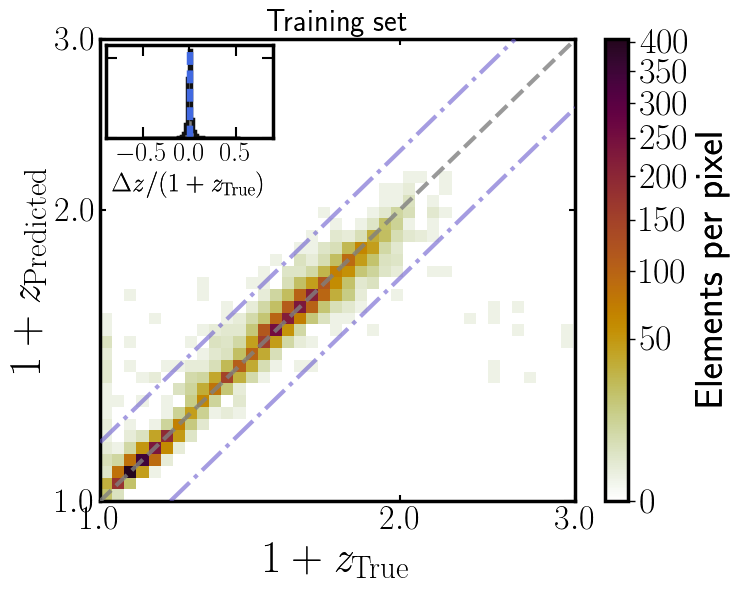

In [77]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(train_prediction_reg.loc[:, target_feat], train_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Training set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_train_redshift_04.pdf', bbox_inches='tight')
plt.show()

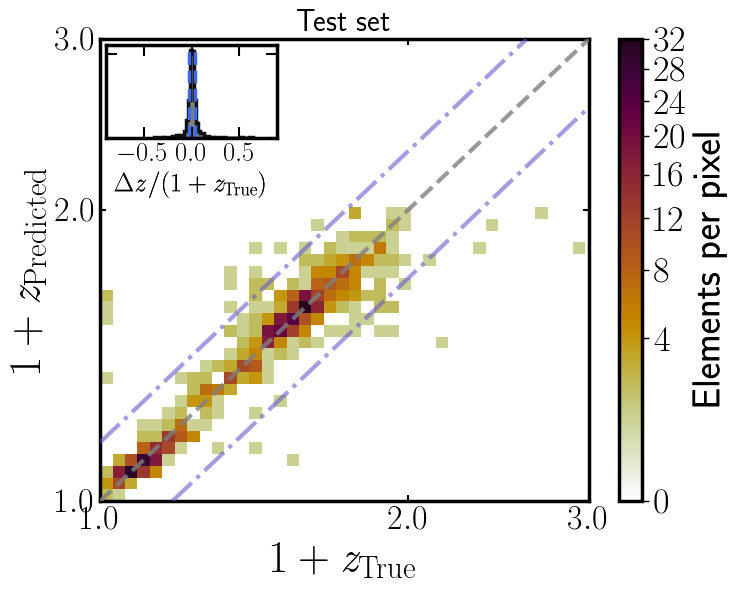

In [78]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(test_prediction_reg.loc[:, target_feat], test_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Test set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_test_redshift_04.pdf', bbox_inches='tight')
plt.show()

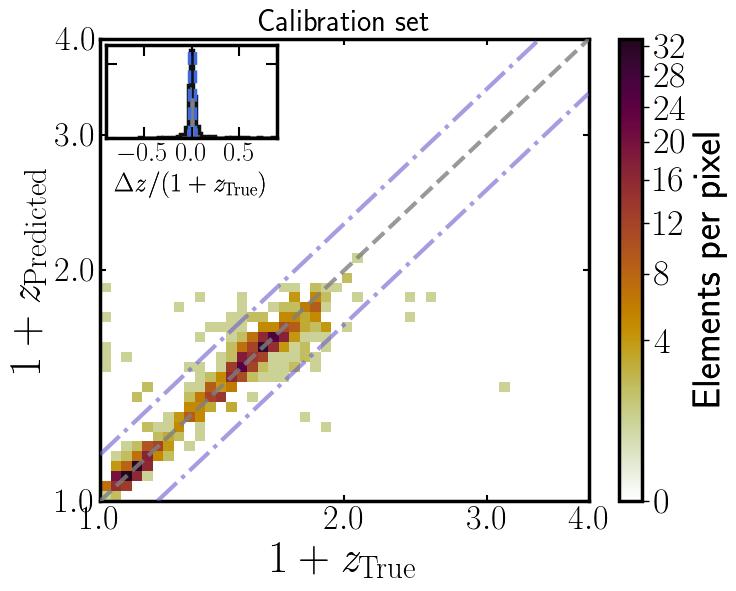

In [79]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(calib_prediction_reg.loc[:, target_feat], calib_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Calibration set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_calibration_redshift_04.pdf', bbox_inches='tight')
plt.show()

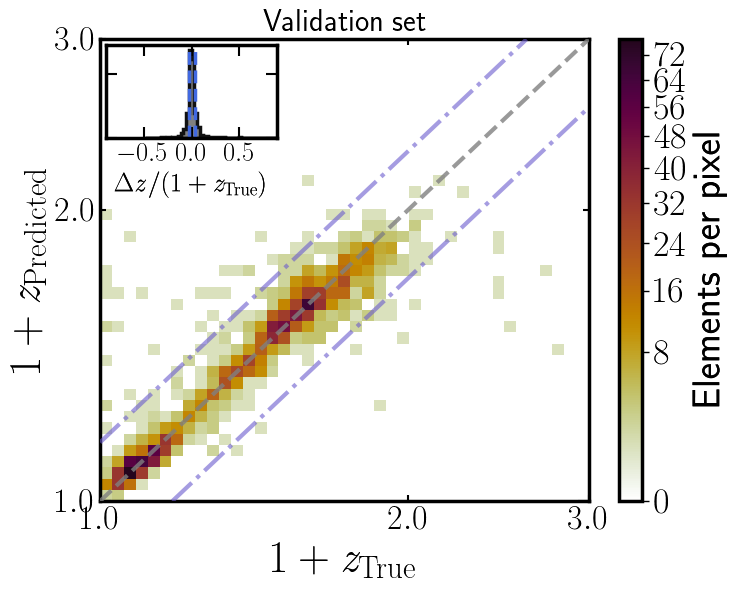

In [80]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Validation set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_validation_redshift_04.pdf', bbox_inches='tight')
plt.show()

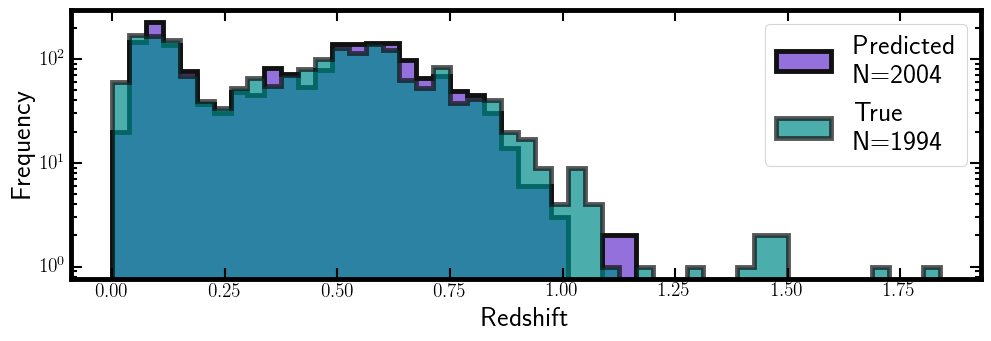

In [81]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(validation_prediction_reg.loc[:, target_feat]),\
                           np.nanmin(validation_prediction_reg.loc[:, 'Label'])])
max_for_range = np.nanmax([np.nanmax(validation_prediction_reg.loc[:, target_feat]),\
                           np.nanmax(validation_prediction_reg.loc[:, 'Label'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)

_, bins, _ = ax1.hist(validation_prediction_reg.loc[:, 'Label'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"Predicted\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Label'] > 0))}")
ax1.hist(validation_prediction_reg.loc[:, target_feat], bins=bins_z, histtype='stepfilled', ec='k', fc='darkcyan',\
         lw=3.5, label=f"True\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Z'] > 0))}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=20)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_true_predicted_z_04.pdf')
plt.show()

### Obtain uncertainty values from model

In [82]:
subsets_arr = [train_prediction_reg, test_prediction_reg, 
               train_test_prediction_reg, calib_prediction_reg, 
               validation_prediction_reg]

In [83]:
subset_names = ['train', 'test', 'train + test', 'calibration', 'validation']

In [84]:
CV_object = KFold(n_splits=10, random_state=gv.seed, shuffle=True)

In [85]:
cv_scores = {}

In [86]:
for count, (subset, subset_name) in enumerate(zip(subsets_arr, subset_names)):
    tmp_s_mads  = []
    tmp_s_nmads = []
    tmp_s_zs    = []
    tmp_s_z_ns  = []
    tmp_out_fs  = []
    for _, fold_index in iter(CV_object.split(subset.loc[:, 'Label'], subset.loc[:, target_feat])):
        tmp_s_mad  = pyr.get_metrics().loc['s_mad', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                       subset.iloc[fold_index].loc[:, 'Label'])
        tmp_s_nmad = pyr.get_metrics().loc['s_nmad', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                    subset.iloc[fold_index].loc[:, 'Label'])
        tmp_s_z    = pyr.get_metrics().loc['s_z', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                          subset.iloc[fold_index].loc[:, 'Label'])
        tmp_s_z_n  = pyr.get_metrics().loc['s_z_n', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                       subset.iloc[fold_index].loc[:, 'Label'])
        tmp_out_f  = pyr.get_metrics().loc['out_f', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                       subset.iloc[fold_index].loc[:, 'Label'])
        tmp_s_mads.append(tmp_s_mad)
        tmp_s_nmads.append(tmp_s_nmad)
        tmp_s_zs.append(tmp_s_z)
        tmp_s_z_ns.append(tmp_s_z_n)
        tmp_out_fs.append(tmp_out_f)
    cv_scores[subset_name] = {'sigma_mad': tmp_s_mads, 'sigma_nmad': tmp_s_nmads, 
                              'sigma_z': tmp_s_zs, 'sigma_z_norm': tmp_s_z_ns, 
                              'outlier_fr':tmp_out_fs}

In [87]:
cv_scores_mean = {}
cv_scores_std  = {}

In [88]:
for sub_set in cv_scores:
    cv_scores_mean[sub_set] = {}
    cv_scores_std[sub_set] = {}
    for score in cv_scores[sub_set]:
        cv_scores_mean[sub_set][score] = np.nanmean(cv_scores[sub_set][score])
        cv_scores_std[sub_set][score]  = np.nanstd(cv_scores[sub_set][score])

In [89]:
for sub_set in cv_scores:
    print('-' * 20 + sub_set + '-' * 20)
    print(f'Sigma MAD score for {sub_set} set:          {cv_scores_mean[sub_set]["sigma_mad"]:.4f} ± {cv_scores_std[sub_set]["sigma_mad"]:.4f}')
    print(f'Sigma NMAD for {sub_set} set:               {cv_scores_mean[sub_set]["sigma_nmad"]:.4f} ± {cv_scores_std[sub_set]["sigma_nmad"]:.4f}')
    print(f'Sigma z for {sub_set} set:                  {cv_scores_mean[sub_set]["sigma_z"]:.4f} ± {cv_scores_std[sub_set]["sigma_z"]:.4f}')
    print(f'Normalized Sigma z score for {sub_set} set: {cv_scores_mean[sub_set]["sigma_z_norm"]:.4f} ± {cv_scores_std[sub_set]["sigma_z_norm"]:.4f}')
    print(f'Outlier fraction for {sub_set} set:         {cv_scores_mean[sub_set]["outlier_fr"]:.4f} ± {cv_scores_std[sub_set]["outlier_fr"]:.4f}')
    print('-' * 55)

--------------------train--------------------
Sigma MAD score for train set:          0.0200 ± 0.0016
Sigma NMAD for train set:               0.0145 ± 0.0011
Sigma z for train set:                  0.0655 ± 0.0207
Normalized Sigma z score for train set: 0.0406 ± 0.0077
Outlier fraction for train set:         0.0089 ± 0.0040
-------------------------------------------------------
--------------------test--------------------
Sigma MAD score for test set:          0.0404 ± 0.0052
Sigma NMAD for test set:               0.0285 ± 0.0037
Sigma z for test set:                  0.1056 ± 0.0298
Normalized Sigma z score for test set: 0.0680 ± 0.0220
Outlier fraction for test set:         0.0383 ± 0.0230
-------------------------------------------------------
--------------------train + test--------------------
Sigma MAD score for train + test set:          0.0231 ± 0.0008
Sigma NMAD for train + test set:               0.0169 ± 0.0006
Sigma z for train + test set:                  0.0790 ± 0.0161


---

#### Redshift threshold

In order to understand where (in redshift) the predictions are far off from real values, we can use the evolution of the outlier fraction to obtain the point where that happens.

In [90]:
n_elems        = 50
z_range_lin    = np.linspace(0, np.nanmax(train_test_prediction_reg.loc[:, target_feat]), n_elems)
z_range_log    = np.logspace(np.log10(np.abs(np.nanmin(train_test_prediction_reg.loc[:, target_feat]))),\
                          np.log10(np.abs(np.nanmax(train_test_prediction_reg.loc[:, target_feat]))), n_elems)
z_range_lg_inv = np.abs(np.abs(np.nanmax(train_test_prediction_reg.loc[:, target_feat]))) - z_range_log

In [91]:
train_test_prediction_reg = train_test_prediction_reg.rename(columns={'Label': 'pred_Z'})

In [92]:
s_MAD_z_z_lin          = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_mad,      target_feat,            'pred_Z')
s_NMAD_z_z_lin         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_nmad,     target_feat,            'pred_Z')
sigma_z_z_z_lin        = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_z,        target_feat,            'pred_Z')
sigma_z_N_z_z_lin      = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_z_norm,   target_feat,            'pred_Z')
out_fr_z_z_lin         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.outlier_frac,   target_feat,            'pred_Z')

In [93]:
s_MAD_z_z_log          = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_mad,      target_feat,            'pred_Z')
s_NMAD_z_z_log         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_nmad,     target_feat,            'pred_Z')
sigma_z_z_z_log        = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_z,        target_feat,            'pred_Z')
sigma_z_N_z_z_log      = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_z_norm,   target_feat,            'pred_Z')
out_fr_z_z_log         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.outlier_frac,   target_feat,            'pred_Z')

In [94]:
s_MAD_z_z_log_inv      = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_mad,      target_feat,            'pred_Z')
s_NMAD_z_z_log_inv     = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_nmad,     target_feat,            'pred_Z')
sigma_z_z_z_log_inv    = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_z,        target_feat,            'pred_Z')
sigma_z_N_z_z_log_inv  = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_z_norm,   target_feat,            'pred_Z')
out_fr_z_z_log_inv     = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.outlier_frac,   target_feat,            'pred_Z')

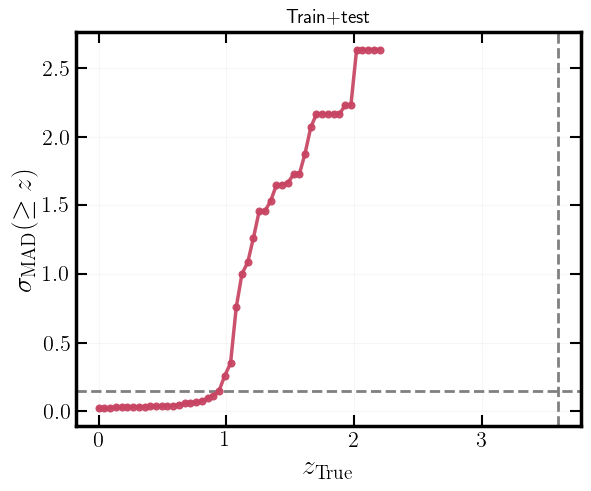

In [95]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_MAD_z_z_lin, '\sigma_{MAD}', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'sigma_mad_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

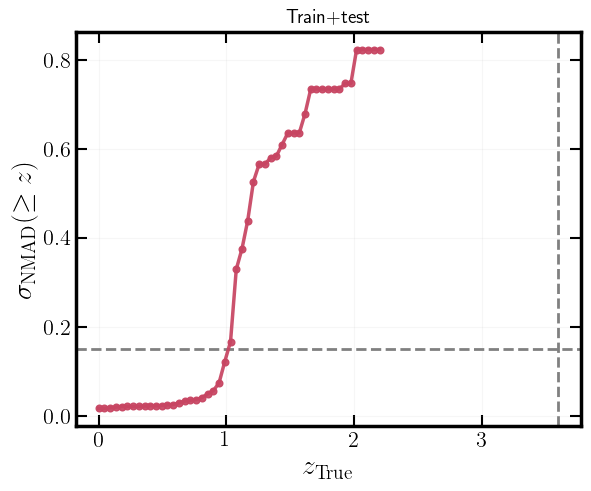

In [96]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_NMAD_z_z_lin, '\sigma_{NMAD}', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'sigma_nmad_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

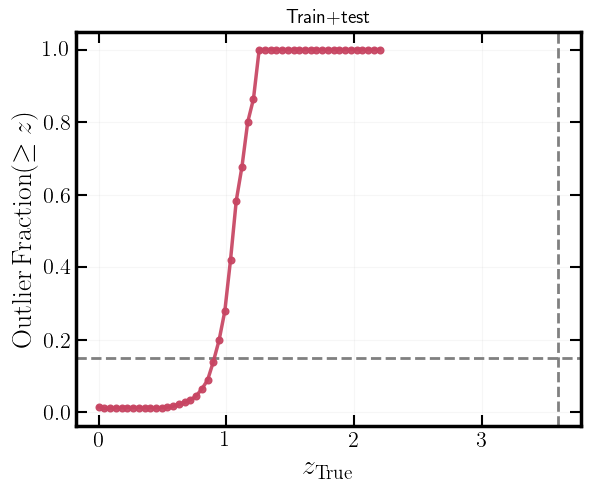

In [97]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, out_fr_z_z_lin, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'outlier_fraction_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='log', yscale='linear')
plot_metric_over_z(z_range_log, out_fr_z_z_log, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'outlier_fraction_log_redshift_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lg_inv, out_fr_z_z_log_inv, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'outlier_fraction_inv_log_redshift_redshift_train_test.pdf', bbox_inches='tight')
plt.show()